In [34]:
import json
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix #, plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
sys.path.append(os.path.join('..', 'src'))

In [4]:
import importlib
import utils, model, params, s05_2_feature_engineering
importlib.reload(utils)
importlib.reload(model)
importlib.reload(params)
importlib.reload(s05_2_feature_engineering)
from utils import build_data_dict
# from model import timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics
from model import get_folders
from params import ProjectParameters
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# set model parameters

In [5]:
target_type = ProjectParameters().target_type
scoring = ProjectParameters().scoring
print('SELECTED TARGET AND SCORING ARE:', target_type, ',', scoring)

SELECTED TARGET AND SCORING ARE: binary , accuracy


# Data capture

In [6]:
inputs, models_reports, model_outputs, reports = get_folders()

data_list = ['X_train', 'X_test', 'X_train_oh', 'X_test_oh', 'X_train_oh', 'X_test_oh', 'y_train', 'y_test']
dfs_dict = build_data_dict(inputs, data_list)

loading data into dictionary


In [7]:
dfs_dict['y_train'] = dfs_dict['y_train']['y'].to_list()
dfs_dict['y_test'] = dfs_dict['y_test']['y'].to_list()

# Machine Learning

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# Calculating final score with a test set

In [10]:
def get_transformations(data_dict, set_name, y_set,
               encoding='ordinal', treat_collinearity = False, build_polynomals_method=False, 
                label_transformation_type=None, do_treat_skewness=False,
               imputation=None, scaler=None,
               ):
    if encoding == 'one-hot':
        set_name = set_name+'_oh'
    elif encoding == 'ordinal':
        set_name = set_name
    if treat_collinearity:
        set_name = set_name+'_oh_nocol'
    X_set = data_dict[set_name]
    
    if build_polynomals_method: 
        X_train_set = build_polynomials(X_set, ProjectParameters().numerical_cols, method = build_polynomals_method)
    if label_transformation_type:
        y_set = transform_label(y_set, label_transformation_type)
    if do_treat_skewness:
        X_set = treat_skewness(X_set, set_name)
        
    if scaler:
        X_set = scale.fit_transform(X_set)
        X_set = pd.DataFrame(X_set, columns = X_set.columns)
    if imputation:
        X_set.fillna(imputation)
    
    return X_set, y_set

In [11]:
def transform_label(df, transformation = None, testing=False):
    print('transform_label function activated')
    df = df.copy()
    if transformation == 'log':
        df = np.log1p(df)
    elif transformation == 'logit':
        max_x = max(df)+1
        min_x = min(df)-1
        df = (df - min_x) / (max_x - min_x)
        df = logit(df)
    if testing: print(df.head())
    return df

In [12]:
transformed_dicts = dfs_dict.copy()
if target_type == 'regression':
    label_transformation_type = 'log'
else:
    label_transformation_type = None
for X,y in zip(['X_train', 'X_test'], ['y_train', 'y_test']):
    transformed_dicts[X], transformed_dicts[y] = get_transformations(
        transformed_dicts, X, transformed_dicts[y],
        encoding='ordinal', build_polynomals_method='simple_square', do_treat_skewness=True,
        imputation=None, scaler=None)

number of columns before building polynomials: 13
number of columns after building polynomials: 18
number of columns before building polynomials: 13
number of columns after building polynomials: 18


# load results
Capture best parameters of chosen model which were obtained during cross validation

In [13]:
def load_json_results(filename):
    filepath = os.path.join(model_outputs, filename+'.json')
    with open(filepath, 'r') as file:
        json_results = json.load(file)
    model = list(json_results.values())[0][ml_model]
    return model

# build model to apply on test set

In [14]:
def build_model(ml_model_type, X_train, y_train, target):
    ml_model = load_json_results(ml_model_type)

    if ml_model_type == 'tree_randomforest':
        params = {}
        for k,v in ml_model['best_params'].items():
            k = k[7:]
            params[k] = v
        print(params)

        regressor = RandomForestRegressor()
        classifier = RandomForestClassifier()

    elif ml_model_type == 'tree_xgboost':
        params = ml_model['best_params']

        regressor = XGBRegressor()
        classifier = XGBClassifier()

    if target == 'regression':
        model = regressor
    elif target == 'binary':
        model = classifier

    for k,v in params.items(): 
        setattr(model, k, v)

    model.fit(X_train, y_train)
    
    return model

In [15]:
# ml_model = 'tree_randomforest'
ml_model = 'tree_xgboost'
model = build_model(ml_model, transformed_dicts['X_train'], transformed_dicts['y_train'], target_type)
y_pred = model.predict(transformed_dicts['X_test'])
y_pred_prob = model.predict_proba(transformed_dicts['X_test'])[:, 1]

# calculate test score 
main metric: mean squared error for regression, f1_score for binary target

In [16]:
test = transformed_dicts['y_test']
[v for v in test if v != 0.0 and v != 1.0]

[]

In [17]:
if target_type == 'regression':
    print('mean squared error:', round(mean_squared_error(transformed_dicts['y_test'], y_pred), 3))
    print('r2_score', round(r2_score(transformed_dicts['y_test'], y_pred),3))
    print('mean_absolute_error', round(mean_absolute_error(transformed_dicts['y_test'], y_pred),3))
elif target_type == 'binary':
    print("\nCLASSIFICATION_REPORT:\n", classification_report(transformed_dicts['y_test'], y_pred))
    print('accuracy_score', round(accuracy_score(transformed_dicts['y_test'], y_pred), 3))
    print('log_loss', round(log_loss(transformed_dicts['y_test'], y_pred), 3))
    print('f1_score', round(f1_score(transformed_dicts['y_test'], y_pred, average='weighted'), 3))
#     plot_confusion_matrix(model, transformed_dicts['X_test'], transformed_dicts['y_test'],
#                      cmap=plt.cm.Blues);


CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

         0.0       0.78      0.89      0.83     12384
         1.0       0.38      0.22      0.28      3897

    accuracy                           0.73     16281
   macro avg       0.58      0.55      0.55     16281
weighted avg       0.69      0.73      0.70     16281

accuracy_score 0.728
log_loss 9.392
f1_score 0.699


# sample prediction
predict first 10 entries

In [18]:
y_pred[:10]

array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

# rebuild model for entire dataset

In [19]:
X = transformed_dicts['X_train'].copy().append(transformed_dicts['X_test'])
y = transformed_dicts['y_train'].copy()
y.extend(transformed_dicts['y_test'])

# ml_model = 'tree_randomforest'
ml_model = 'tree_xgboost'
final_model = build_model(ml_model, X, y, target_type)

# save pickle of results

In [20]:
file = os.path.join(model_outputs, 'trained_model.pkl')
with open(file, 'wb') as f:
    pickle.dump(final_model, f)  

# Seção de processos decisórios

# Ordena as entradas em ordem de maior para menor probabilidade de superar a barreira de 50k
Recupera ID e ordena de acordo com a probabilidade.

Obs: estou fazendo a estimativa apenas com a base que foi separada para teste. Se quisesse ordenar toda a base, teria que fazer k folds, por exemplo com k=3, semelhante ao que foi feito mais acima com k-fold cross-validation. O motivo disso é que eu não posso usar uma mesma base tanto para treino como para estimativa, pois isso vicia os resultados (overfitting).

In [21]:
X_train = transformed_dicts['X_train']
X_test = transformed_dicts['X_test']
y_test = transformed_dicts['y_test']

In [22]:
index_name = X_train.index.name
y_pred = y_pred_prob
ordered_users = pd.DataFrame(list(zip(X_test.index, y_pred, y_test)), columns = [index_name, 'probabilidade', 'valor_verdadeiro']).set_index(index_name)
ordered_users.sort_values(by='probabilidade', ascending=False, inplace=True)
ordered_users.head()

,probabilidade,valor_verdadeiro
id,,
13747,0.986509,0.0
2901,0.986293,1.0
3040,0.985857,1.0
16261,0.985250,1.0
619,0.984879,1.0


Observa número de usuários do teste e quantidade que recomprou

In [23]:
users_total = len(ordered_users)
users_yes = len(ordered_users[ordered_users['valor_verdadeiro'] == 1])
users_no = users_total - users_yes
print('Número de usuários sendo testados:', users_total)
print('Número de usuários que recompraram:', users_yes, 'ou {}% do total'.format(round(users_yes/users_total*100, 2)))
print('Número de usuários que não recompraram:', users_no, 'ou {}% do total'.format(round(users_no/users_total*100, 2)))

Número de usuários sendo testados: 16281
Número de usuários que recompraram: 3897 ou 23.94% do total
Número de usuários que não recompraram: 12384 ou 76.06% do total


# Análise de thresholds
Vamos comparar alguns thresholds de probabilidades para tomada de decisão, assumindo "1" apenas se usuário tiver mais de um threshold de probabilidade de fazer nova compra e "0" caso contrário.

### Precision Recall Curve

Sendo TP=True Positives, FP=False Positives, TN=True Negatives e FN=False Negatives:
* Precision é dado por: $\frac{TP}{TP+FP}$
* Recall (sensitivity) é dado por: $\frac{TP}{TP+FN}$

FP são os casos em que o modelo classifica incorretamente como positivo casos que são na verdade negativos. Nesse problema, diria que fará nova compra alguém que na verdade não fará. Enquanto que o recall mede o quanto do total de casos de fato positivos foram corretamente capturados, precision mostra qual proporção de casos classificados como positivos pelo modelo são de fato positivos

Há outras formas de mensurar efeitos ilustram a capacidade de classificação binária ao variar o threshold. Por exemplo, a curva ROC (receiver operating characteristic) demonstra o quanto de aumento no TPR (True Positive Rate) acarreta em FPR (False Positive Rate). Apesar da utilidade do gráfico, acreditamos que a curva precision-recall já seria suficiente.

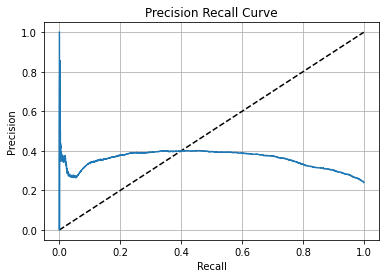

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

Pelo que podemos ver no gráfico, até um recall em torno de 0.8 (e precision em torno de 0.6), é possível aumentá-lo sem uma queda mais acentuada de precisão.

Se considerarmos um threshold de 50%, ou seja, fazer uma campanha para quem tiver a partir 50% de probabilidade de reagir à mesma, teremos uma precisão de 40% e atingiremos 22% dos usuários de interesse.

In [25]:
thres_index = np.where(thresholds>=0.5)[0][0]
print('threshold:', round(thresholds[thres_index],2))
print('precision:', round(precisions[thres_index],2))
print('recall:', round(recalls[thres_index],2))

threshold: 0.5
precision: 0.38
recall: 0.22


Vamos reduzir a threshold e ver o que acontece.

In [26]:
thres_index = np.where(thresholds>=0.15)[0][0]
print('threshold:', round(thresholds[thres_index],2))
print('precision:', round(precisions[thres_index],2))
print('recall:', round(recalls[thres_index],2))

threshold: 0.15
precision: 0.38
recall: 0.66


In [27]:
thres_index = np.where(thresholds>=0.1)[0][0]
print('threshold:', round(thresholds[thres_index],2))
print('precision:', round(precisions[thres_index],2))
print('recall:', round(recalls[thres_index],2))

threshold: 0.1
precision: 0.36
recall: 0.75


Até aqui, nos parece fazer sentido reduzir o threshold em prol do aumento de recall.

In [28]:
thres_index = np.where(thresholds>=0.01)[0][0]
print('threshold:', round(thresholds[thres_index],2))
print('precision:', round(precisions[thres_index],2))
print('recall:', round(recalls[thres_index],2))

threshold: 0.01
precision: 0.25
recall: 0.99


Ao reduzir excessivamente o threshold, aumentamos o número de usuários de interesse atingidos por campanha, mas ao custo de alta redução da precisão. Ou seja, estamos investindo muito dinheiro em muita gente que não reagirá, apesar de aumentarmos também o número de reações. Isso quer dizer que o ROI (Retorno do Investimento) tem risco de diminuir.

Vamos analisar a variação em termos absolutos de usuários atingidos por uma campanha.

### Cria listas de valores acumulados

Listas de booleanos:
* unique_prob: Das probabilidades duplicadas, marca "1" somente se for a última duplicada, para salvar a quantidade de usuários atendidos para aquela prob.
* in_threshold: Das probabilidades, marca "1" se está entre os thresholds obtidos na curva precision-recall e se estiver marcado como único, marca "1" somente se for a última duplicada, para salvar a quantidade de usuários atendidos para aquela prob.

In [29]:
ordered_users['unique_prob'] = ~ordered_users.duplicated(subset = 'probabilidade', keep='last')

ordered_users['in_threshold'] = ordered_users[ (ordered_users['unique_prob'] == True) 
                                              & (ordered_users['probabilidade'].isin(thresholds)) ].probabilidade

unique_prob = ordered_users['unique_prob'].to_list()
in_threshold = ordered_users['in_threshold'].to_list()
ordered_users.drop(['in_threshold', 'unique_prob'], axis=1, inplace=True)

Cria listas de valores acumulados correspondentes à lista de thresholds

In [30]:
cum_positive = ordered_users.valor_verdadeiro.cumsum().to_list()

cum_positive_filtered = []
cum_target_users = []
for i,val in enumerate(in_threshold):
    if not math.isnan(val):
        cum_value_pos = cum_positive[i]
        cum_positive_filtered.append(cum_value_pos)
        cum_target_users.append(i)
        
cum_positive_filtered = list(reversed(cum_positive_filtered))
cum_target_users = list(reversed(cum_target_users))

## Compara números absolutos
Vamos usar números absolutos agora para ter uma dimensão do tamanho do investimento em termos de usuários.

In [31]:
cum_positive_filtered.append(cum_positive_filtered[-1])
cum_target_users.append(cum_target_users[-1])

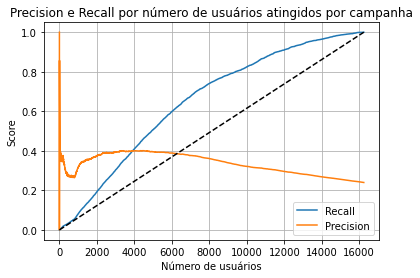

In [32]:
plt.plot(cum_target_users, recalls)
plt.plot(cum_target_users, precisions)
plt.plot([0, max(cum_target_users)], [0, 1], 'k--')
plt.grid()
plt.legend(labels  = ['Recall', 'Precision'])
plt.xlabel('Número de usuários')
plt.ylabel('Score')
plt.title('Precision e Recall por número de usuários atingidos por campanha')
plt.show()

### Compara resultados positivos com números absolutos em cada threshold
Note que essa curva é idêntica ao recall, mas é agora em número absolutos em vez de proporção.

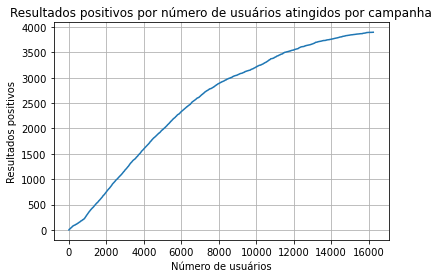

In [33]:
plt.plot(cum_target_users, cum_positive_filtered)
plt.grid()
plt.xlabel('Número de usuários')
plt.ylabel('Resultados positivos')
plt.title('Resultados positivos por número de usuários atingidos por campanha')
plt.show()

# Considerações finais

Explicando em termos absolutos, se eu estivesse investindo somente nos 8000 usuários de maior probabilidade de responder à campanha, conseguiríamos 3000 novas fidelizações, mas que almejarmos aumentar esse número para 4000 (1/3 de aumento!), seria necessário mais do que dobrar esse investimento, ou seja, superar 16000 usuários compreendidos!

Portanto, minha indicação seria utilizar o threshold próximo a 0.1 (10% de probabilidade de reação). Com isso, ajudamos a fidelizar uma boa quantidade de clientes, mas evitamos também um custo muito alto que reduza nosso ROI, levando em conta que consideramos um custo marginal baixo.

Além disso, as equipes que possuíssem interesse em avaliar as variáveis mais importantes poderiam consultar os resultados de feature importances. 